
=== Chr1 | Crossover at 539 | Swap ABOVE ===
Chromosome Gene  Position Chr1_Before Chr2_Before Chr1_After Chr2_After
      Chr1    C       210           C           c          C          c
      Chr1    P       336           P           p          P          p
      Chr1    S       462           S           s          S          s
      Chr1    D       601           D           d          d          D
      Chr1    H       717           H           h          h          H
      Chr1    E      1013           E           e          e          E
      Chr1    F      1166           F           f          f          F

=== Chr2 | Crossover at 994 | Swap ABOVE ===
Chromosome Gene  Position Chr1_Before Chr2_Before Chr1_After Chr2_After
      Chr2    A       258           A           a          A          a
      Chr2    T       381           T           t          T          t
      Chr2    Q       397           Q           q          Q          q
      Chr2    B       951           B       

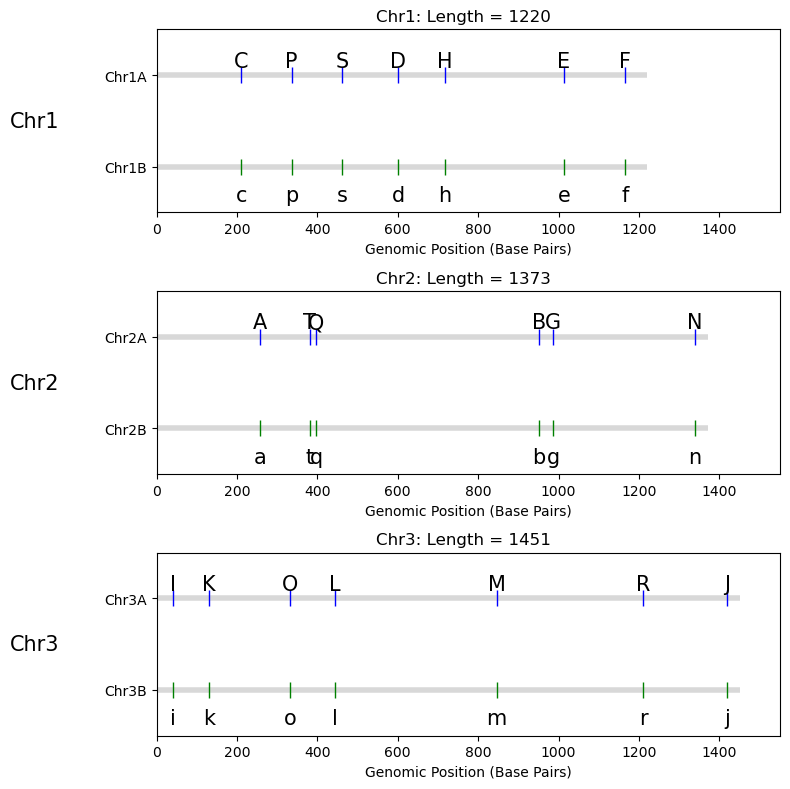

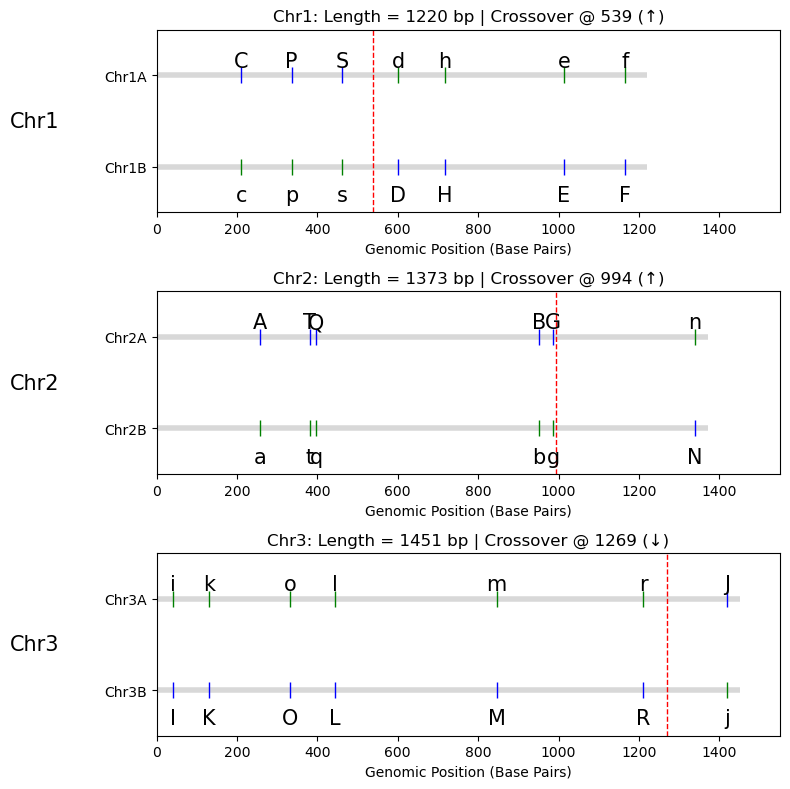

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from itertools import combinations
import random  
import string
import pandas as pd
from functions import *

random.seed(407) 

# Step 1: Distribute 20 genes across 3 chromosomes with at least 6 genes each
def distribute_genes(total_genes=20, chromosomes=3, min_genes=6):
    while True:
        sizes = [min_genes] * chromosomes
        remaining = total_genes - sum(sizes)
        for _ in range(remaining):
            sizes[random.randint(0, chromosomes - 1)] += 1
        if sum(sizes) == total_genes:
            return sizes

gene_counts = distribute_genes()

# Step 2: Assign gene names
all_genes = list(string.ascii_uppercase[:20])
random.shuffle(all_genes)

# Step 3: Simulate chromosomes
chromosomes_data = []

gene_idx = 0
for chr_num, gene_count in enumerate(gene_counts, 1):
    # Random chromosome length
    chr_length = random.randint(1000, 2000)
    
    # Gene names
    gene_names = all_genes[gene_idx:gene_idx + gene_count]
    
    # Ensure even distribution - at least one gene per quarter
    quarter = chr_length // 4
    required_positions = [random.randint(i * quarter + 1, (i + 1) * quarter) for i in range(4)]
    
    remaining = gene_count - 4
    remaining_positions = random.sample(range(1, chr_length), remaining)
    
    # Remove duplicates just in case, then re-sample if needed
    unique_remaining = list(set(remaining_positions) - set(required_positions))
    while len(unique_remaining) < remaining:
        # Add more unique positions until we reach the required number
        new_pos = random.randint(1, chr_length)
        if new_pos not in required_positions and new_pos not in unique_remaining:
            unique_remaining.append(new_pos)
    
    positions = sorted(required_positions + unique_remaining[:remaining])
    genes = list(zip(gene_names, positions))
    
    # Create homologous chromosomes (Before recombination)
    chr1 = [(f"{g}", pos) for g, pos in genes]
    chr2 = [(f"{g}", pos) for g, pos in genes]
    
    # Recombination: Define crossover point
    crossover = random.randint(1, chr_length)

    # Set the probability of swapping all genes above or all genes below the crossover point
    swap_probability = 0.5  # 50% probability to swap either above or below

    # Decide whether to swap genes above or below the crossover point
    swap_above = random.random() < swap_probability
    
    recombinant1 = []
    recombinant2 = []
    
    for (g1, pos), (g2, _) in zip(chr1, chr2):
        if (swap_above and pos > crossover) or (not swap_above and pos < crossover):
            recombinant1.append((g2.lower(), pos))  # Gene from chr2 to chr1 (lowercase)
            recombinant2.append((g1.upper(), pos))  # Gene from chr1 to chr2 (uppercase)
        else:
            recombinant1.append((g1.upper(), pos))  # Gene from chr1 to chr1 (uppercase)
            recombinant2.append((g2.lower(), pos))  # Gene from chr2 to chr2 (lowercase)
    
    # Create DataFrame for the current chromosome pair
    df = pd.DataFrame({
        "Chromosome": f"Chr{chr_num}",
        "Gene": gene_names,
        "Position": positions,
        "Chr1_Before": [g.upper() for g, _ in chr1],
        "Chr2_Before": [g.lower() for g, _ in chr2],
        "Chr1_After": [g for g, _ in recombinant1],
        "Chr2_After": [g for g, _ in recombinant2],
    })
    
    chromosomes_data.append((f"Chr{chr_num}", crossover, swap_above, df, chr_length))
    gene_idx += gene_count

 

for chr_name, crossover, swap_above, df,chr_length in chromosomes_data:
    print(f"\n=== {chr_name} | Crossover at {crossover} | Swap {'ABOVE' if swap_above else 'BELOW'} ===")
    print(df.to_string(index=False))


# Get the max chromosome length to normalize others against it (for consistent visual scaling)
max_length = max(chr_length for _, _, _, _, chr_length in chromosomes_data)

# Find max chromosome length for consistent x-axis scaling
max_length = max(chr_length for _, _, _, _, chr_length in chromosomes_data)

# Create subplots for the chromosomes (before and after)
# 3 subplots for "before" and 3 subplots for "after"
fig_before, axs_before = plt.subplots(3, 1, figsize=(8, 8), sharex=False)  
fig_after, axs_after = plt.subplots(3, 1, figsize=(8, 8), sharex=False)

# Loop through the first 3 chromosomes (for "before" and "after" plots)
for i, (chr_name, crossover, swap_above, df, chr_length) in enumerate(chromosomes_data[:3]):
    # Plot BEFORE swapping (Chr1_Before, Chr2_Before, Chr3_Before)
    ax_before = axs_before[i]  # Using the first column for 'before' plots
    ax_before.set_xlim(0, max_length + 100)
    ax_before.set_ylim(-2, 2)
    
    # Set the title for "before" plot
    ax_before.set_title(f"{chr_name}: Length = {chr_length}  ")

    # Horizontal bars representing chromosomes BEFORE swapping
    ax_before.hlines(1, 0, chr_length, color='gray', linewidth=4, alpha=0.3)  # Chr1_Before
    ax_before.hlines(-1, 0, chr_length, color='gray', linewidth=4, alpha=0.3) # Chr2_Before


    # Plot Chr1_Before genes
    for g, pos in zip(df["Chr1_Before"], df["Position"]):
        color = 'blue' if g.isupper() else 'green'
        ax_before.plot(pos, 1, marker="|", color=color, markersize=12)
        ax_before.text(pos, 1.1, g, rotation=0, fontsize=15, ha='center', va='bottom')

    # Plot Chr2_Before genes
    for g, pos in zip(df["Chr2_Before"], df["Position"]):
        color = 'blue' if g.isupper() else 'green'
        ax_before.plot(pos, -1, marker="|", color=color, markersize=12)
        ax_before.text(pos, -1.4, g, rotation=0, fontsize=15, ha='center', va='top')

    # Y-axis labels as chromosome names, rotated vertically
    ax_before.set_ylabel(chr_name, rotation=0, labelpad=50, fontsize=15, va='center')

    # Set y-tick labels
    ax_before.set_yticks([-1, 1])

    if i == 0:
        ax_before.set_yticks([1, -1])
        ax_before.set_yticklabels(["Chr1A", "Chr1B"])
    elif i == 1:
        ax_before.set_yticks([1, -1])
        ax_before.set_yticklabels(["Chr2A", "Chr2B"])
    elif i == 2:
        ax_before.set_yticks([1, -1])
        ax_before.set_yticklabels(["Chr3A", "Chr3B"])

    # Set the x and y axis labels
    ax_before.set_xlabel("Genomic Position (Base Pairs)")

    
    ax_before.set_xlabel("Genomic Position (Base Pairs)")

    # Plot AFTER swapping (Chr1_After, Chr2_After, Chr3_After)
    ax_after = axs_after[i]  # Using the second column for 'after' plots
    ax_after.set_xlim(0, max_length + 100)
    ax_after.set_ylim(-2, 2)
    
    # Set the title for "after" plot
    ax_after.set_title(f"{chr_name}: Length = {chr_length} bp | Crossover @ {crossover} ({'↑' if swap_above else '↓'})")

    # Horizontal bars representing chromosomes AFTER swapping
    ax_after.hlines(1, 0, chr_length, color='gray', linewidth=4, alpha=0.3)  # Chr1_After
    ax_after.hlines(-1, 0, chr_length, color='gray', linewidth=4, alpha=0.3) # Chr2_After
    
    # Red vertical crossover line
    ax_after.axvline(crossover, color='red', linestyle='--', linewidth=1)

    # Plot Chr1_After genes
    for g, pos in zip(df["Chr1_After"], df["Position"]):
        color = 'blue' if g.isupper() else 'green'
        ax_after.plot(pos, 1, marker="|", color=color, markersize=12)
        ax_after.text(pos, 1.1, g, rotation=0, fontsize=15, ha='center', va='bottom')

    # Plot Chr2_After genes
    for g, pos in zip(df["Chr2_After"], df["Position"]):
        color = 'blue' if g.isupper() else 'green'
        ax_after.plot(pos, -1, marker="|", color=color, markersize=12)
        ax_after.text(pos, -1.4, g, rotation=0, fontsize=15, ha='center', va='top')

    # Y-axis labels as chromosome names, rotated vertically
    ax_after.set_ylabel(chr_name, rotation=0, labelpad=50, fontsize=15, va='center')

    # Set y-tick labels
    ax_after.set_yticks([-1, 1])

    if i == 0:
        ax_after.set_yticks([1, -1])
        ax_after.set_yticklabels(["Chr1A", "Chr1B"])
    elif i == 1:
        ax_after.set_yticks([1, -1])
        ax_after.set_yticklabels(["Chr2A", "Chr2B"])
    elif i == 2:
        ax_after.set_yticks([1, -1])
        ax_after.set_yticklabels(["Chr3A", "Chr3B"])
    
    ax_after.set_xlabel("Genomic Position (Base Pairs)")

# Save the "before" plot
fig_before.tight_layout()
fig_before.savefig("chromosomes_before.png")

# Save the "after" plot
fig_after.tight_layout()
fig_after.savefig("chromosomes_after.png")

# Optionally, show the plots if you want to visualize them
plt.show()


/tmp/ipykernel_1859/499384312.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = df_split.applymap(encode_genotype)


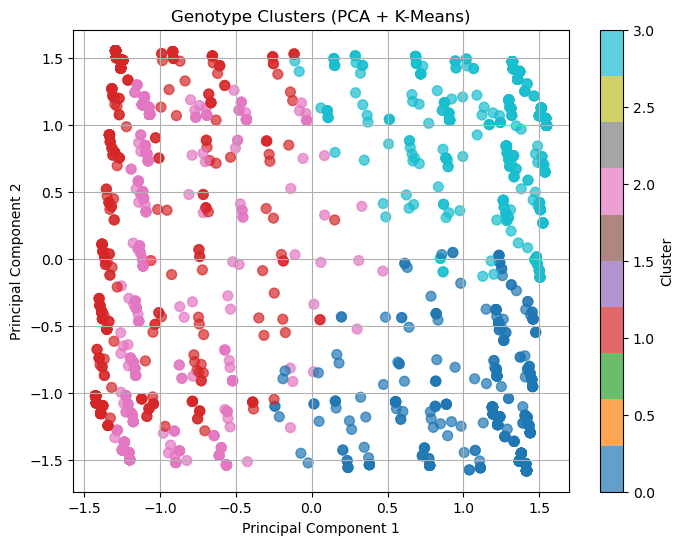

In [8]:
# df_split = df_genotypes["Genotype"].str.split("/", expand=True)
# df_split.columns = [f"G{i+1}" for i in range(df_split.shape[1])]

# def encode_genotype(g):
#     g = ''.join(sorted(g, key=str.lower)) 
#     if g[0].isupper() and g[1].isupper():
#         return 2  
#     elif g[0].islower() and g[1].islower():
#         return 0 
#     else:
#         return 1  

# df_encoded = df_split.applymap(encode_genotype)

# pca = PCA(n_components=2)
# components = pca.fit_transform(df_encoded)

# k = 4  
# kmeans = KMeans(n_clusters=k, random_state=42)
# clusters = kmeans.fit_predict(df_encoded)

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(
#     components[:, 0],
#     components[:, 1],
#     c=clusters,
#     cmap="tab10",  
#     s=50,
#     alpha=0.7
# )

# plt.title("Genotype Clusters (PCA + K-Means)")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.grid(True)
# plt.colorbar(scatter, label="Cluster")
# plt.show()